#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выгрузка-необходимых-библиотек" data-toc-modified-id="Выгрузка-необходимых-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выгрузка необходимых библиотек</a></span></li><li><span><a href="#Выгрузка-и-анализ-данных" data-toc-modified-id="Выгрузка-и-анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Выгрузка и анализ данных</a></span></li><li><span><a href="#Ресемлирование-данных" data-toc-modified-id="Ресемлирование-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ресемлирование данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Общий-график" data-toc-modified-id="Общий-график-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общий график</a></span></li><li><span><a href="#График-скользящего-среднего" data-toc-modified-id="График-скользящего-среднего-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>График скользящего среднего</a></span></li><li><span><a href="#График-сезонности" data-toc-modified-id="График-сезонности-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>График сезонности</a></span></li><li><span><a href="#Разница-временных-рядов" data-toc-modified-id="Разница-временных-рядов-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разница временных рядов</a></span></li><li><span><a href="#Итог-анализа" data-toc-modified-id="Итог-анализа-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Итог анализа</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Деление-данных-на-выборки" data-toc-modified-id="Деление-данных-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Деление данных на выборки</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Модель-Catboost-Regressor" data-toc-modified-id="Модель-Catboost-Regressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель Catboost Regressor</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

Заказчик - компания такси - собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Надо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

### Выгрузка необходимых библиотек

Для начала выгрузим все необходимые для решения задачи библиотеки

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
RANDOM = 12345

Библиотеки выгружены - приступим к выгрузке данных.

### Выгрузка и анализ данных

Вырузим наш датасет в переменную df. Сразу передадим индексирующий столбец 'datetime', чтобы в дальнейшем не тратить время на это.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Методом info() выведем информацию о нашем датасете на экран.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


Теперь наш датасет имеет колонку-индекс "Дата/время" и колонку с информацией "Число заказов", а также 26496 строк. 

Методом is_monotonic проверим - расположены ли наши данные в хронологическом порядке, так как это важно для дальнейшего обучения модели.

In [4]:
df = df.sort_index(ascending=True)
print(df.index.is_monotonic)
df.info()

True

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


Метод дал вывод "True", что говорит о хронологическом порядке расположения данных. Проверим данные на предмет пропусков.

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Как мы видим - данные не имеют пропусков, а значит, с ними можно спокойно работать.

### Ресемлирование данных

Для дальнейшего анализа произведем ресемплирование данных столбца 'datetime', т.е. изменим интервал со значением временного ряда. В нашем задании новый интервал будет составлять 1 час. Применим его.

In [6]:
df = df.resample('1H').sum()

Произвели ресемплирование данных в интервале 1 часа. Приступим к непосредственному анализу данных.

## Анализ

### Общий график 

Анализировать данные начнем с графика ресемплированного временного ряда. Для этого построим его методом plot().

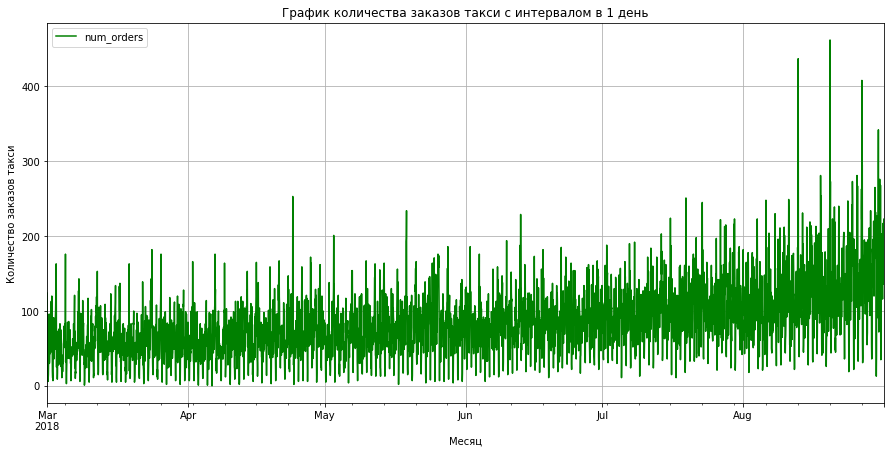

In [7]:
df.plot(figsize=(15,7), 
        color='g', 
        grid=True, 
        title = 'График количества заказов такси с интервалом в 1 день', 
        xlabel = 'Месяц',
        ylabel = 'Количество заказов такси')

plt.show()

### График скользящего среднего

Сейчас построим график скользящего среднего, т.е. значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

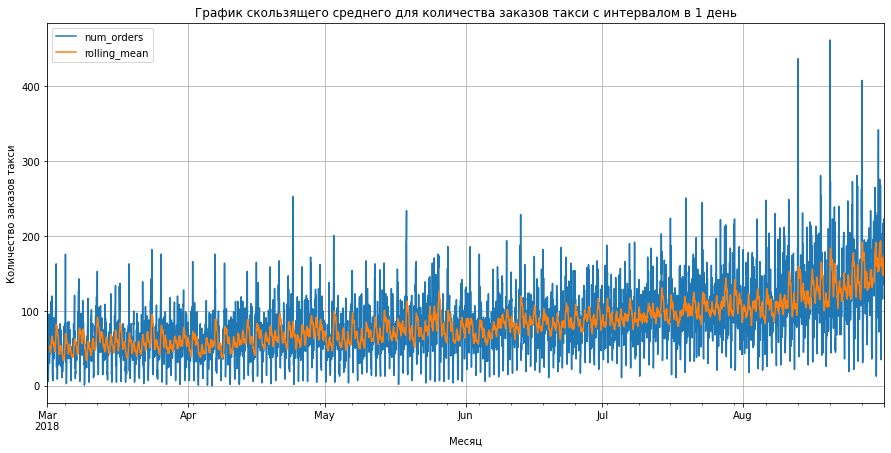

In [8]:
df_c = df.copy()
df_c['rolling_mean'] = df_c.rolling(15).mean()
df_c.plot(figsize=(15,7), 
        grid=True,
        title = 'График скользящего среднего для количества заказов такси с интервалом в 1 день', 
        xlabel = 'Месяц',
        ylabel = 'Количество заказов такси')

plt.show()


Смотря на крафик скользящего среднего, можно сделать вывод, что начиная с июля количество заказов такси в аэропортах растет - это связано с массовым летним сезоном отпусков. Можно сказать, что это сезонный тренда, но удостовериться в этом поможет график сезонности заказов. 

### График сезонности

Построим его с помощью метода seasonal_decompose(), который раскладывает временной ряд на три составляющие:
- тренд 
- сезонность 
- остаток (это компонента, которая не объясняется трендом и сезонностью, т.е. шум)

In [9]:
df_c['num_orders'] = df_c['num_orders'].fillna(0)

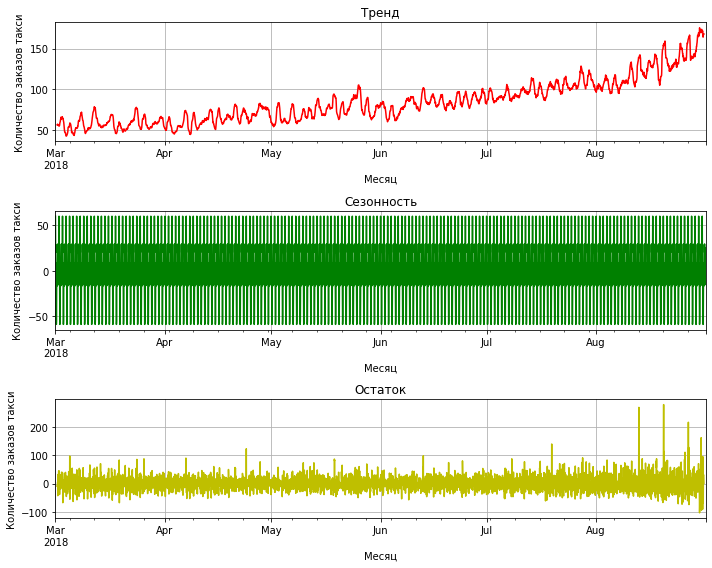

In [10]:
decomposed = seasonal_decompose(df_c['num_orders'])

plt.figure(figsize=(10, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), 
                      grid=True, 
                      color='r', 
                      title='Тренд',
                      xlabel = 'Месяц', 
                      ylabel = 'Количество заказов такси')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), 
                         grid=True, 
                         color='g', 
                         title='Сезонность',
                         xlabel = 'Месяц', 
                         ylabel = 'Количество заказов такси')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), 
                      grid=True, 
                      color='y', 
                      title='Остаток',
                      xlabel = 'Месяц', 
                      ylabel = 'Количество заказов такси')
plt.tight_layout()

Как мы видим из графика - увеличение заказов такси в аэропортах действительно тренд, который увеличивается в летние месяцы (месяцы отпусков), начиная с июля. Также предлагаю рассмотреть более детально по летним месяцам график сезонности. Построим его, например, для июля и для августа.  

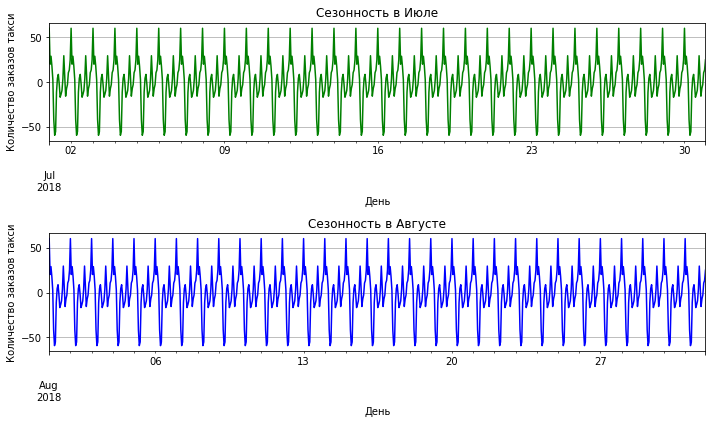

In [11]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.seasonal['2018-07-01' : '2018-07-30'].plot(grid=True, 
                                                      color='g',
                                                      title='Сезонность в Июле',
                                                      xlabel = 'День', 
                                                      ylabel = 'Количество заказов такси')
plt.subplot(312)
decomposed.seasonal['2018-08-01' : '2018-08-31'].plot(grid=True, 
                                                      color='b',
                                                      title='Сезонность в Августе',
                                                      xlabel = 'День', 
                                                      ylabel = 'Количество заказов такси')
plt.tight_layout()

На графиках видно, что пик заказов приходится на конец недели/выходные, а в понедельник наблюдается спад. Также незначительный спад идет и в середине недели. И так в каждом месяце.

Теперь рассмотрим сезонность на промежутке 2-е суток в июле и августе.

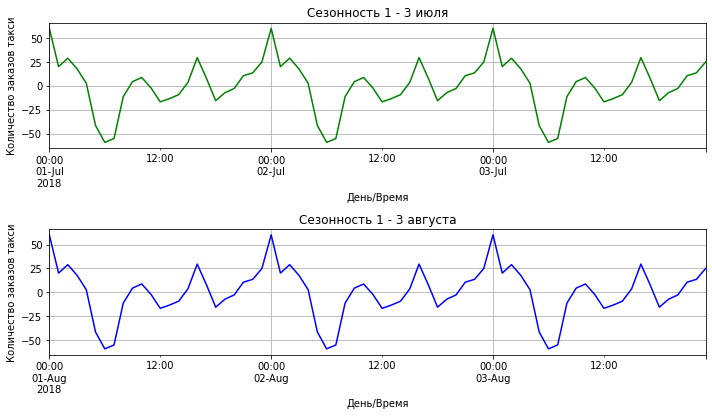

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.seasonal['2018-07-01' : '2018-07-03'].plot(grid=True, 
                                                      color='g',
                                                      title='Сезонность 1 - 3 июля',
                                                      xlabel = 'День/Время', 
                                                      ylabel = 'Количество заказов такси') 
plt.subplot(312)
decomposed.seasonal['2018-08-01' : '2018-08-03'].plot(grid=True, 
                                                      color='b',
                                                      title='Сезонность 1 - 3 августа',
                                                      xlabel = 'День/Время', 
                                                      ylabel = 'Количество заказов такси')
plt.tight_layout()

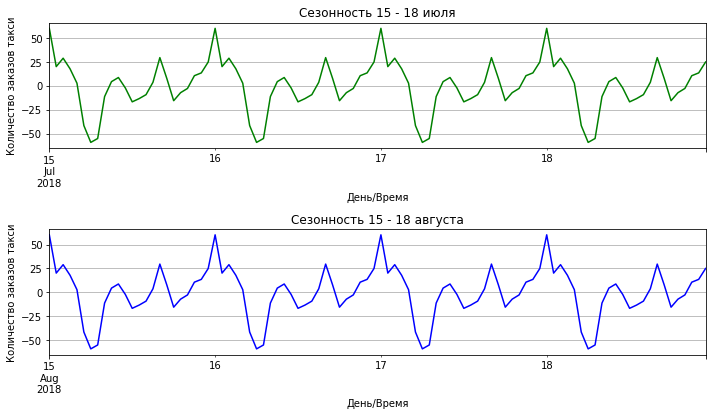

In [13]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.seasonal['2018-07-15' : '2018-07-18'].plot(grid=True, 
                                                      color='g',
                                                      title='Сезонность 15 - 18 июля',
                                                      xlabel = 'День/Время', 
                                                      ylabel = 'Количество заказов такси')
plt.subplot(312)
decomposed.seasonal['2018-08-15' : '2018-08-18'].plot(grid=True, 
                                                      color='b',
                                                      title='Сезонность 15 - 18 августа',
                                                      xlabel = 'День/Время', 
                                                      ylabel = 'Количество заказов такси')
plt.tight_layout()

Как мы видим из графиков - пик заказов приходится на ночное время (действительно, многие люди вылетают/прилетают по ночам, так как это удобнее). Также это можно объяснить отсутсвием сильного трафика на дорогах, а следовательно возможностью добраться до места назначения быстрее. По этим же причинам прослеживается и сезонный спад заказов в утренние часы - движение затрудненное и времени на поездку будет тратиться гораздо больше. В среднем количество заказов в течение дня (до 18:00) примерно одинаковое в наших промежутках - активизируется лишь ближе к вечеру.

### Разница временных рядов

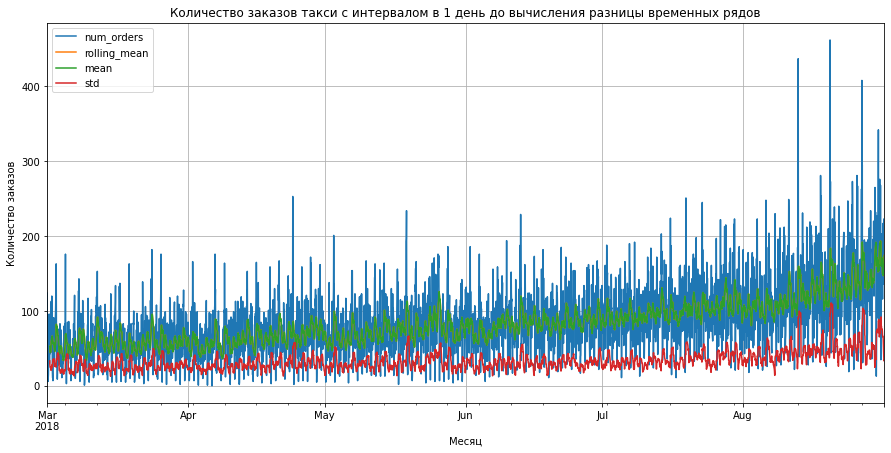

In [14]:
df_c['mean'] = df_c['num_orders'].rolling(15).mean()
df_c['std'] = df_c['num_orders'].rolling(15).std() 
df_c.plot(figsize=(15,7), grid=True)
plt.title('Количество заказов такси с интервалом в 1 день до вычисления разницы временных рядов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Изначально на графике было видно, что временной ряд нестационарный - у него меняется среднее значение и стандартное отклонение (исходя из первого графика). Чтобы сделать временной ряд более стационарным воспользуемся разницей временных рядов. Для этого будем использовать метод shift, который сдвигает все значения ряда на 1 назад, заполинв следующее значение "0", и посмотрим что из этого получится.

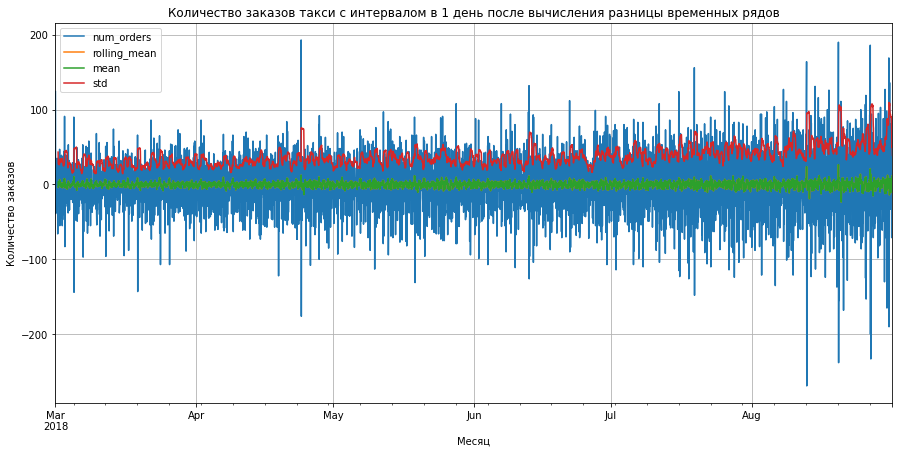

In [15]:
df_c-= df_c.shift(fill_value=0)
df_c['mean'] = df_c['num_orders'].rolling(15).mean()
df_c['std'] = df_c['num_orders'].rolling(15).std()
df_c.plot(figsize=(15,7), grid=True)
plt.title('Количество заказов такси с интервалом в 1 день после вычисления разницы временных рядов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Временной ряд стал более стационарным - его среднее и стандартное отклоенение примерно составляют линии. Теперь этот ряд можно прогнозировать. Перейдем к обучению моделей.

### Итог анализа

Нами был произведен общий анализ предоставленных данных. 

Мы ресемлировали даты для интервала в 1 час, затем из графиков распределения временного ряда пришли к выводу, что ряд не является стационарным - по графику заметно, что у него происходят отклонения среднего значения. Затем мы построили график скользящего среднего и выяснили, какие значения наименьше всего в нашем ряду подвержены колебаниям.

После был произведен разбор сезонности временного ряда в результате которого оказалось, что тренд на большее количество заказов начинается в июле, что может быть связано с популярностью и большим количеством отпусков в данном промежутке времени. Также было замечено, что посреди недели и в понедельники наблюдается спад заказов, а своего пика они достигают в выходные (также можно судить о бОльшем количестве вылетов/прилетов в выходные дни, нежели в будние).

Также, отдельно, нами была рассмотрена сезонность заказов такси в промежутке 2 дня в разные числа июля и августа. На основании графиков был сделан вывод, что пик заказов приходится на ночное время (действительно, многие люди вылетают/прилетают по ночам, так как это удобнее). Также это можно объяснить отсутсвием сильного трафика на дорогах, а следовательно возможностью добраться до места назначения быстрее. По этим же причинам прослеживается и сезонный спад заказов в утренние часы - движение затрудненное и времени на поездку будет тратиться гораздо больше. В среднем количество заказов в течение дня (до 18:00) примерно одинаковое в наших промежутках - активизируется лишь ближе к вечеру.

В конце мы построили график разности временных рядов - чтобы ряд стал более стационарным (его среднее и стандартное отклонение примерно стали составлять линии).

Можно переходить к обучению моделей

## Обучение

### Создание признаков

Задача прогнозирования временного ряда состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда. Но при этом, наших признаков будет недостаточно, чтобы грамотно сделать прогноз. Поэтому, лучше всего создать дополнительные признаки - выделить из столбца 'datetime' дни и дни недели. Для этого мы создадим функцию make_features, которая на вход будет принимать сам датасет, максимальное количество отстающих значений и скользящее среднее. А на выходе будет давать таблицу признаков, которые затем мы загрузим в модель.

In [16]:
df_1 = df.copy()

def make_features(df, max_lag, rolling_mean_size):
    df_1['day'] = df_1.index.day
    df_1['dayofweek'] = df_1.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_1['lag_{}'.format(lag)] = df_1['num_orders'].shift(lag)

    df_1['rolling_mean'] = df_1['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_1

In [17]:
df1 = make_features(df, 24, 15)

Функция написана - перейдем к делению данных на выборки

### Деление данных на выборки

Перед обучением необходимо разделить наши данные на выборки. Для этого воспользуемся методом train_test_split и сделаем тестовую выборку равную 10% исходных данных. Соответственно, на тренировочную выборку уйдет 90%. При этом необходимо помнить, что перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

In [18]:
train, test = train_test_split(df1, shuffle=False, test_size=0.1, random_state=RANDOM)
train=train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)

(3950, 27) (3950,)

(442, 27) (442,)


Данные разбиты на выборки, мы посмотрели также их размерность - она составляет 90/10, как и задумывалось. Теперь создадим функцию для кросс-валидации наших данных. Это необходимо, так как валидационной выборки у нас нет.

Создадим функцию Cross-validation RMSE (cv_rmse), которая будет на вход принимать модель, данные (тренировочные или тестовые), колонку целевого признака, количество делений для валидации и максимальный размер обучающих данных. Она и будет считать нашу искомую RMSE

In [19]:
def cv_rmse(model, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        X_train = train.drop(target_column, axis=1)
        y_train = train[target_column]
        X_test = test.drop(target_column, axis=1)
        y_test = test[target_column]
        model.fit(X_train, y_train)
        RMSE += mean_squared_error(y_test, model.predict(X_test)) ** 0.5
    return RMSE / n_splits

In [20]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3

Функция написана - перейдем к обучению моделей. Для решения данной задачи будем пользоваться 4-мя моделями:
- Линейная регрессия
- Случайный лес
- Дерево решений
- CatBoost

### Модель линейной регрессии

In [21]:
model = LinearRegression()
rmse_lr = cv_rmse(model, train, 'num_orders', cv_splits, cv_train_test_split)
print('Метрика RMSE для модели Линейной Регрессии на тренировочной выборке составляет:', rmse_lr)

Метрика RMSE для модели Линейной Регрессии на тренировочной выборке составляет: 27.73713680432518


### Модель случайного леса

Для начала подберем лучшие гиперпараметры моделе с помощью GridSearch().

In [23]:
model = RandomForestRegressor(random_state=RANDOM, n_jobs=-1) 
est = [x for x in range(10, 100, 20)]
params = [{'criterion':['mse'], 
          'n_estimators':est}]

clf = GridSearchCV(model, params, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)
best_params_rf = clf.best_params_
best_score_rf = clf.best_score_
print("Лучшие гиперпараметры для модели:")
print()
print(best_params_rf)
print()
print("Лучшая метрика RMSE с лучшими гиперпараметрами:")
print()
print(-best_score_rf)

Лучшие гиперпараметры для модели:



{'criterion': 'mse', 'n_estimators': 70}



Лучшая метрика RMSE с лучшими гиперпараметрами:



24.53438813046381


### Модель дерева решений

In [24]:
model = DecisionTreeRegressor(random_state=RANDOM) 
depth = [None] + [i for i in range(2, 10)]
params = [{'criterion':['mse'], 
          'max_depth':depth}]

clf = GridSearchCV(model, params, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)
best_params_dt = clf.best_params_
best_score_dt = clf.best_score_
print("Лучшие гиперпараметры для модели:")
print()
print(best_params_dt)
print()
print("Лучшая метрика RMSE с лучшими гиперпараметрами:")
print()
print(-best_score_dt)

Лучшие гиперпараметры для модели:



{'criterion': 'mse', 'max_depth': 5}



Лучшая метрика RMSE с лучшими гиперпараметрами:



28.617808329589685


### Модель Catboost Regressor

По аналогии с RF и DT подберем гиперпараметры, а затем обучим на них модель.

In [25]:
model = CatBoostRegressor(random_state=RANDOM) 
params = [{'learning_rate':[i/10 for i in range(1, 6)]}]

clf = GridSearchCV(model, params, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)
best_params_cb = clf.best_params_
best_score_cb = clf.best_score_

print("Лучшие гиперпараметры для модели:")
print()
print(best_params_cb)
print()
print("Лучшая метрика RMSE с лучшими гиперпараметрами:")
print()
print(-best_score_cb)

0:	learn: 37.3213217	total: 56.4ms	remaining: 56.3s

1:	learn: 35.8078350	total: 64.7ms	remaining: 32.3s

2:	learn: 34.7199432	total: 74.4ms	remaining: 24.7s

3:	learn: 33.6206757	total: 84.2ms	remaining: 21s

4:	learn: 32.6982683	total: 94ms	remaining: 18.7s

5:	learn: 31.9048078	total: 103ms	remaining: 17.1s

6:	learn: 31.1183992	total: 113ms	remaining: 16.1s

7:	learn: 30.3824788	total: 123ms	remaining: 15.3s

8:	learn: 29.7618066	total: 132ms	remaining: 14.5s

9:	learn: 29.1717960	total: 141ms	remaining: 13.9s

10:	learn: 28.6911363	total: 150ms	remaining: 13.5s

11:	learn: 28.2986714	total: 159ms	remaining: 13.1s

12:	learn: 27.9184739	total: 168ms	remaining: 12.7s

13:	learn: 27.5625693	total: 177ms	remaining: 12.4s

14:	learn: 27.2137220	total: 185ms	remaining: 12.2s

15:	learn: 26.9431142	total: 194ms	remaining: 12s

16:	learn: 26.6399705	total: 201ms	remaining: 11.6s

17:	learn: 26.4012405	total: 210ms	remaining: 11.4s

18:	learn: 26.2055973	total: 218ms	remaining: 11.3s

19:	

### Результаты

Итого, у нас получились следующие метрики RMSE.

In [26]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'DecisionTreeRegressor',
         'CatBoostRegressor']
scores = {'Метрика RMSE на тренировочной выборке с кросс-валидацией':[rmse_lr,
                      -best_score_rf,
                      -best_score_dt,
                      -best_score_cb]}

date_1 = pd.DataFrame(data=scores, index=index)
date_1

,Метрика RMSE на тренировочной выборке с кросс-валидацией
LinearRegression,27.737137
RandomForestRegressor,24.534388
DecisionTreeRegressor,28.617808
CatBoostRegressor,23.763185


Наименьшую метрику RMSE на тренировочной выборке показывает модель CatBoost Regressor. Посмотрим как она покажет себя на тестовой выборке.

## Тестирование

Как показало прогнозирование на тренировочной выборке - наименьшую метрику RMSE показала модель CatBoost Regressor. Сделаем предсказания с ее использованием на тестовых данных и посмотрим ошибку. Также построим график ошибок.

In [27]:
model = CatBoostRegressor(random_state=RANDOM) 
model.fit(X_train, y_train)
test_pred_cb = model.predict(X_test)
test_rmse_cb = mean_squared_error(y_test, test_pred_cb, squared=False)
print('Метрика RMSE для модели CB на тестовой выборке составляет:', 
      test_rmse_cb)


Learning rate set to 0.050868

0:	learn: 37.8318428	total: 7.78ms	remaining: 7.77s

1:	learn: 36.9418420	total: 13.9ms	remaining: 6.91s

2:	learn: 36.1903741	total: 19.6ms	remaining: 6.52s

3:	learn: 35.4479216	total: 26.5ms	remaining: 6.6s

4:	learn: 34.7473988	total: 33ms	remaining: 6.57s

5:	learn: 34.0850943	total: 39.1ms	remaining: 6.47s

6:	learn: 33.4882999	total: 45.4ms	remaining: 6.45s

7:	learn: 32.9310636	total: 50.9ms	remaining: 6.3s

8:	learn: 32.4008919	total: 57.7ms	remaining: 6.35s

9:	learn: 31.8929734	total: 66.5ms	remaining: 6.58s

10:	learn: 31.4019325	total: 75.1ms	remaining: 6.75s

11:	learn: 30.9805148	total: 83.7ms	remaining: 6.89s

12:	learn: 30.5597480	total: 91.1ms	remaining: 6.92s

13:	learn: 30.1536513	total: 97ms	remaining: 6.83s

14:	learn: 29.7851827	total: 103ms	remaining: 6.75s

15:	learn: 29.4369522	total: 109ms	remaining: 6.69s

16:	learn: 29.1057025	total: 118ms	remaining: 6.8s

17:	learn: 28.7782554	total: 126ms	remaining: 6.88s

18:	learn: 28.4759

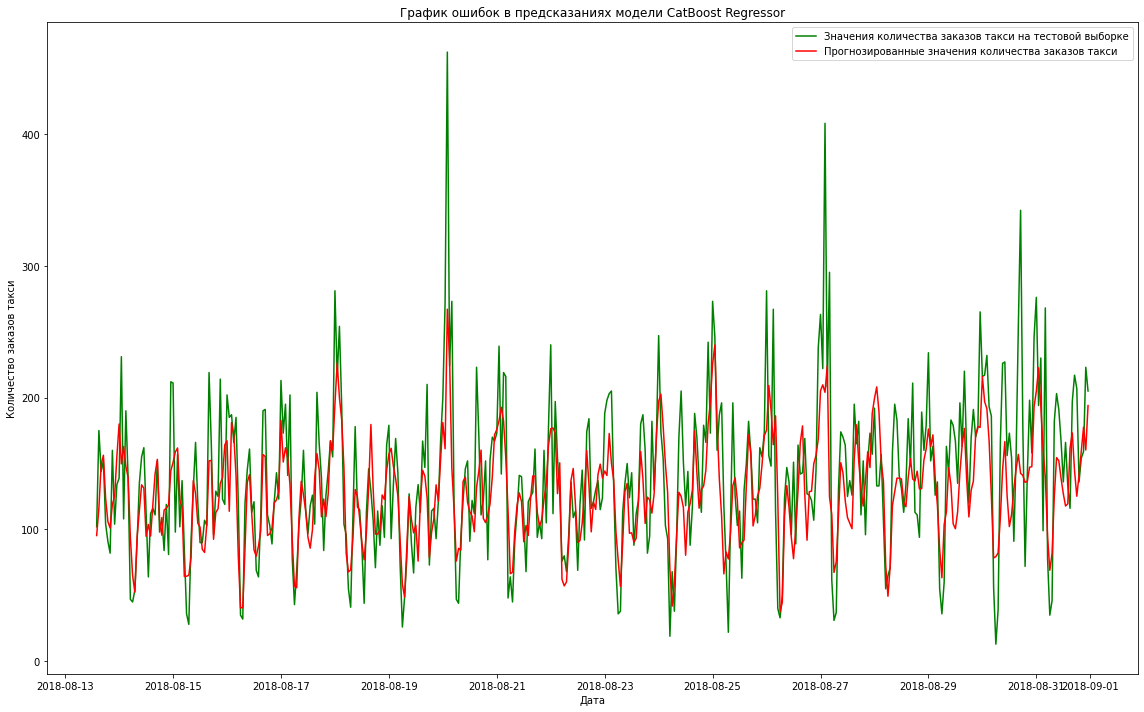

In [28]:
plt.figure(figsize=(16,10))
plt.plot(y_test.index, 
         y_test, 
         color = 'g', 
         label ='Значения количества заказов такси на тестовой выборке')
plt.plot(y_test.index, 
         test_pred_cb,
         color = 'r',
         label ='Прогнозированные значения количества заказов такси')
plt.legend()
plt.title('График ошибок в предсказаниях модели CatBoost Regressor')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.tight_layout()

Как мы видим - метрика RMSE для модели CatBoost Regressor на тестовой выборке составляет 41,04, что входит в наше пороговое значение (до 48). Сравним ее с метрикой константной модели, чтобы понять - не прогнозирует ли наша модель среднее по выборке.

In [29]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
dummy_rmse = mean_squared_error(y_test, dummy_pred, squared=False)
print('Метрика RMSE для константной модели на тестовой составляет:', 
      dummy_rmse)

Метрика RMSE для константной модели на тестовой составляет: 84.6499381993622


Разница очевидна. Таким образом, наша модель CatBoost Regressor справляется с поставленной задачей, а значит, ее можно рекомендовать заказчику.

## Общий вывод


Для начала мы ресемлировали даты для интервала в 1 час (так как это было необходимо по задаче). Далее, мы рассмотрели графики распределения временного ряда и пришли к выводу, что ряд не является стационарным - по графику заметно, что у него происходят отклонения среднего значения. Затем мы построили график скользящего среднего и выяснили, какие значения наименьше всего в нашем ряду подвержены колебаниям.

После этого нами был произведен разбор сезонности временного ряда. Как оказалось из полученных графиков - тренд на большее количество заказов начинается в июле, что может быть связано с популярностью и большим количеством отпусков в данном промежутке времени. Также было замечено, что посреди недели и в понедельники наблюдается спад заказов, а своего пика они достигают в выходные (также можно судить о бОльшем количестве вылетов/прилетов в выходные дни, нежели в будние).

Также, отдельно, нами была рассмотрена сезонность заказов такси в промежутке 2 дня в разные числа июля и августа. На основании графиков был сделан вывод, что пик заказов приходится на ночное время (действительно, многие люди вылетают/прилетают по ночам, так как это удобнее). Также это можно объяснить отсутсвием сильного трафика на дорогах, а следовательно возможностью добраться до места назначения быстрее. По этим же причинам прослеживается и сезонный спад заказов в утренние часы - движение затрудненное и времени на поездку будет тратиться гораздо больше. В среднем количество заказов в течение дня (до 18:00) примерно одинаковое в наших промежутках - активизируется лишь ближе к вечеру.

В конце мы построили график разности временных рядов - чтобы ряд стал более стационарным (его среднее и стандартное отклонение примерно стали составлять линии). Теперь этот ряд можно было прогнозировать. 

Для составления прогнозов нами было выбрано 4 модели регрессии:

- LinearRegression,
- RandomForestRegressor,
- DecisionTreeRegressor,
- CatBoostRegressor

Для каждой из них нам необходимо было расчитать метрику средней квадратичной ошибки. Для начала мы создали функцию, которая добавила следующие столбцы: "день" и "день недели". Это было необходимо, чтобы при обучении моделей учитывались сезонность и трендовость временного ряда. 

Затем мы разбили наши данные на тренировочную и тестовую выборки в пропорции 90/10 соответственно. Также написали функцию для кросс-валидации при обучении.

Обучив модели на тренировочной выборке, мы выяснили, что лучшая метрика RMSE у модели CatBoost Regressor и составляет 23,7. Затем мы сделали прогноз с использованием данной модели на тестовой выборке и получили значение среднеквадратичной ошибки равное 41,04. Также мы сравнили прогноз нашей модели с прогнозом константной модели, чтобы исключить ситуацию, когда наша модель просто прогнозировала бы среднее значение по выборке. Метрика RMSE на константной моделе оказалась значительно выше 84,64), что говорит об адекватности прогнозирования выбранной нами модели.

Таким образом, после всех анализов и рассчетов, модель CatBoost Regressor можно смело рекомендовать заказчику и быть уверенным, что она справится с поставленной задачей прогнозирования количества заказов такси в аэропорте на следующий час.